In [299]:
%reset -f

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mstats

sns.set_style("whitegrid")

## Define functions

In [301]:
def generate_dataset(n_clients, mean_age=50, std_age=15, age_bounds=(15, 100), 
                     income_multiplier_range=(1000, 3000), income_bounds=(0, 300000), 
                     spending_multiplier_range=(0.1, 0.3), spending_bounds=(0, 70000), 
                     outlier_fraction=0.01, outlier_multiplier=1.5,
                     gender_proportion=(0.5, 0.5), type_proportions=(0.9, 0.08, 0.02)):
    """
    Generates a dataset with fake clients including demographic information.
    """
    np.random.seed(42)

    # Generate CLIENT_ID
    client_ids = np.arange(1, n_clients + 1)

    # Generate AGE with some outliers
    ages = np.random.normal(mean_age, std_age, n_clients)
    ages = np.clip(ages, *age_bounds)
    outlier_ages = np.random.choice(n_clients, int(n_clients * outlier_fraction), replace=False)
    ages[outlier_ages] += np.random.choice([-1, 1], len(outlier_ages)) * outlier_multiplier * std_age

    # Generate INCOME, correlated with AGE
    income_base = ages * np.random.uniform(*income_multiplier_range, n_clients)
    income = np.clip(income_base + np.random.normal(0, income_bounds[1] / 10, n_clients), *income_bounds)
    outlier_income = np.random.choice(n_clients, int(n_clients * outlier_fraction), replace=False)
    income[outlier_income] *= outlier_multiplier

    # Generate SPENDING, correlated with both AGE and INCOME
    spending_base = income * np.random.uniform(*spending_multiplier_range, n_clients)
    spending = np.clip(spending_base + np.random.normal(0, spending_bounds[1] / 10, n_clients), *spending_bounds)
    outlier_spending = np.random.choice(n_clients, int(n_clients * outlier_fraction), replace=False)
    spending[outlier_spending] *= outlier_multiplier

    # Generate GENDER
    genders = np.random.choice(['M', 'F'], size=n_clients, p=gender_proportion)

    # Generate TYPE
    types = np.random.choice(['A', 'B', 'C'], size=n_clients, p=type_proportions)

    # Create the DataFrame
    df = pd.DataFrame({
        'CLIENT_ID': client_ids,
        'AGE': np.round(ages, 2),
        'INCOME': np.round(income, 2),
        'SPENDING': np.round(spending, 2),
        'GENDER': genders,
        'TYPE': types
    })

    return df

In [302]:
def visualize_distribution(data, column_name, bins='auto', title=None, xlabel=None, ylabel='Density'):
    """
    Lets you visualize the distribution of a numeric variable
    """
    # Set plot size for better visibility
    plt.figure(figsize=(10, 6))
    
    # Set default titles and labels if not provided
    if title is None:
        title = f'Distribution of {column_name}'
    if xlabel is None:
        xlabel = column_name
    
    # Plot histogram and KDE
    sns.histplot(data[column_name], bins=bins, kde=True, stat="density", linewidth=0.5, alpha=0.7)
    
    # Set titles and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Show plot
    plt.show()


In [303]:
def visualize_categorical_proportion(data, column_name, title=None, xlabel=None, ylabel='Percentage'):
    """
    Visualize the distribution of a categorical variable as percentages using a bar chart.
    """
    # Calculate the percentages
    percentage_data = (data[column_name].value_counts(normalize=True) * 100).reset_index()
    percentage_data.columns = [column_name, 'Percentage']
    
    # Set plot size for better visibility
    plt.figure(figsize=(8, 6))
    
    # Set default titles and labels if not provided
    if title is None:
        title = f'Percentage Distribution of {column_name}'
    if xlabel is None:
        xlabel = column_name
    
    # Create the bar plot using seaborn
    sns.barplot(x=column_name, y='Percentage', data=percentage_data, palette='viridis', order=percentage_data[column_name])
    
    # Set titles and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Ensure the y-axis ticks represent percentages
    plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(decimals=0))
    
    # Show plot
    plt.show()



## Generate fake data

In [304]:

df = generate_dataset(n_clients=80000)
df.head()

,CLIENT_ID,AGE,INCOME,SPENDING,GENDER,TYPE
0,1,57.45,154620.42,29160.67,F,A
1,2,47.93,61916.66,8721.83,F,A
2,3,59.72,135786.09,28055.06,F,A
3,4,72.85,134581.88,40885.18,M,A
4,5,46.49,126064.41,17923.89,M,A


## Visualize and winsorize variables

### Age

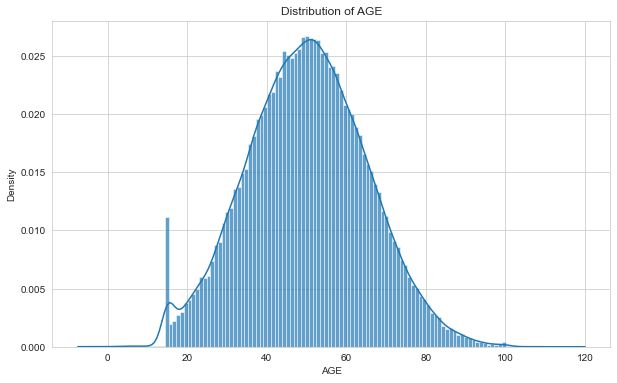

In [305]:
visualize_distribution(df, 'AGE')

In [306]:
df['AGE'].quantile([0,0.02,0.99,1])

0.00     -7.50
0.02     18.88
0.99     85.37
1.00    120.02
Name: AGE, dtype: float64

In [307]:
# Winsorize Age to deal with extreme values

df = df.assign(AGE_WINSOR = mstats.winsorize(df['AGE'], limits=[0.02, 0.01]))
df['AGE_WINSOR'].quantile([0,0.25,.5,.75,1])

0.00    18.88
0.25    39.76
0.50    50.08
0.75    60.27
1.00    85.37
Name: AGE_WINSOR, dtype: float64

In [308]:
# Make categorical bins for stratification

df['AGE_QUARTILES'] = pd.qcut(df['AGE_WINSOR'], 4, labels = ['19 to 40', '40 to 50', '50 to 60', '60 to 85'])
df['AGE_QUARTILES'].value_counts()

40 to 50    20010
19 to 40    20007
50 to 60    19998
60 to 85    19985
Name: AGE_QUARTILES, dtype: int64

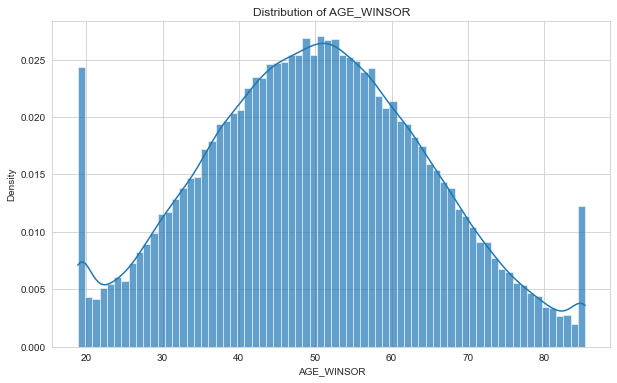

In [309]:
visualize_distribution(df, 'AGE_WINSOR')

### Income

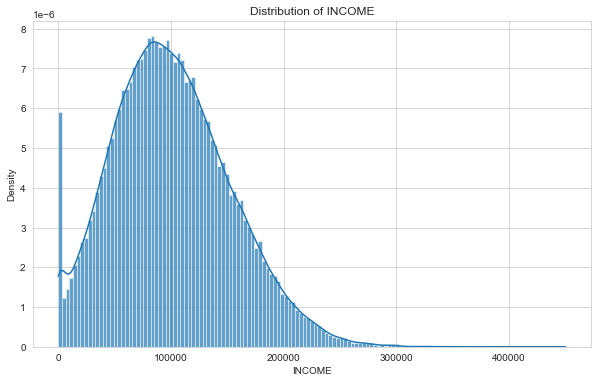

In [310]:
visualize_distribution(df, 'INCOME')

In [311]:
df['INCOME'].quantile([0,0.02,0.9999,1])

0.0000         0.000000
0.0200      3714.962200
0.9999    352157.114693
1.0000    450000.000000
Name: INCOME, dtype: float64

In [312]:
# Winsorize Income to deal with extreme values

df = df.assign(INCOME_WINSOR = mstats.winsorize(df['INCOME'], limits=[0, 0.0001]))
df['INCOME_WINSOR'].quantile([0,0.25,.5,.75,1])

0.00         0.0000
0.25     63352.0425
0.50     96955.9500
0.75    134329.1750
1.00    352154.9300
Name: INCOME_WINSOR, dtype: float64

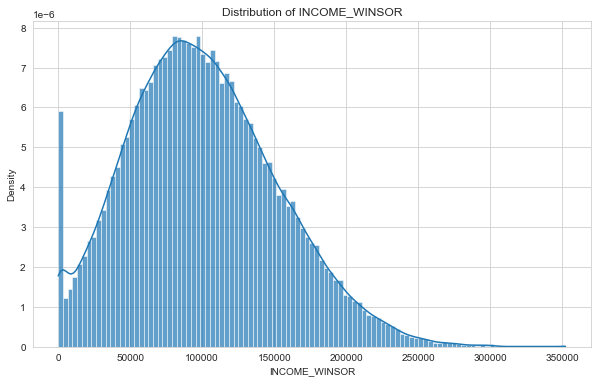

In [313]:
visualize_distribution(df, 'INCOME_WINSOR')

In [314]:
# Make categorical bins for stratification

df['INCOME_QUARTILES'] = pd.qcut(df['INCOME_WINSOR'], 4, labels = ['0 to 63,352', '63,352 to 96,956', '96,956 to 134,329', '134,329 to 352,155'])
df['INCOME_QUARTILES'].value_counts()

134,329 to 352,155    20000
96,956 to 134,329     20000
63,352 to 96,956      20000
0 to 63,352           20000
Name: INCOME_QUARTILES, dtype: int64

### Spending

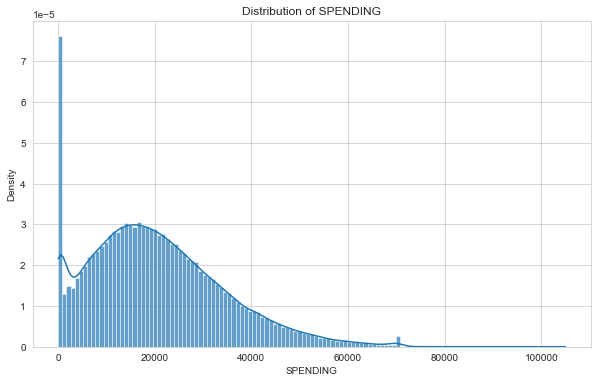

In [315]:
visualize_distribution(df, 'SPENDING')

In [316]:
df['SPENDING'].quantile([0,0.02,0.999,1])

0.000         0.0
0.020         0.0
0.999     70000.0
1.000    105000.0
Name: SPENDING, dtype: float64

In [317]:
# Winsorize SPENDING to deal with extreme values

df = df.assign(SPENDING_WINSOR = mstats.winsorize(df['SPENDING'], limits=[0, 0.001]))
df['SPENDING_WINSOR'].quantile([0,0.25,.5,.75,1])

0.00        0.00
0.25    10263.54
0.50    18793.40
0.75    28786.02
1.00    70000.00
Name: SPENDING_WINSOR, dtype: float64

In [318]:
# Make categorical bins for stratification

df['SPENDING_QUARTILES'] = pd.qcut(df['SPENDING_WINSOR'], 4, labels = ['0 to 10,264', '10,264 to 18,793', '18,793 to 28,786', '28,786 to 70,000'])
df['SPENDING_QUARTILES'].value_counts()

28,786 to 70,000    20000
18,793 to 28,786    20000
10,264 to 18,793    20000
0 to 10,264         20000
Name: SPENDING_QUARTILES, dtype: int64

### Gender

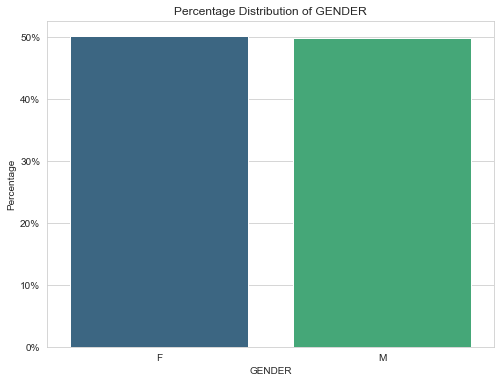

In [319]:
visualize_categorical_proportion(df, "GENDER")

### Type

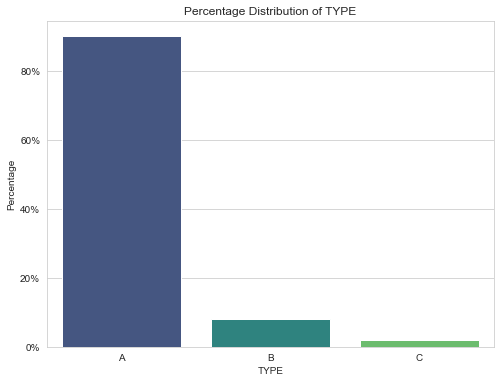

In [320]:
visualize_categorical_proportion(df, 'TYPE')

### Create strata and assign treatment group

In [321]:
# Create strata

df_sorted = df.sort_values(by=['TYPE', 'AGE_QUARTILES', 'INCOME_QUARTILES', 'SPENDING_QUARTILES'])
df_sorted['stratum_id'], _ = pd.factorize(df_sorted[['TYPE', 'AGE_QUARTILES', 'INCOME_QUARTILES', 'SPENDING_QUARTILES']].apply(tuple, axis=1))


In [322]:
strata_counts = df_sorted['stratum_id'].value_counts()
strata_counts # there are 186 strata

63     6276
0      6202
47     3278
16     2691
1      2456
       ... 
174       1
153       1
140       1
76        1
99        1
Name: stratum_id, Length: 187, dtype: int64

In [323]:
(strata_counts == 1).sum() # There are 5 strata with only one client

5

In [324]:
# Turn strata_counts into a dataframe

strata_counts_df = strata_counts.reset_index()
strata_counts_df.columns = ['stratum_id', 'stratum_count']
strata_counts_df

,stratum_id,stratum_count
0,63,6276
1,0,6202
2,47,3278
3,16,2691
4,1,2456
...,...,...
182,174,1
183,153,1
184,140,1
185,76,1


In [325]:
# Add a column showing how many rows one would have to remove so that the remaining number of rows are divisible by 8

strata_counts_df['rows_to_remove'] = strata_counts_df['stratum_count'] % 8

strata_counts_df

,stratum_id,stratum_count,rows_to_remove
0,63,6276,4
1,0,6202,2
2,47,3278,6
3,16,2691,3
4,1,2456,0
...,...,...,...
182,174,1,1
183,153,1,1
184,140,1,1
185,76,1,1


In [326]:
# Percentage of missfits: 0.78%
str(100 * strata_counts_df['rows_to_remove'].sum() / strata_counts_df['stratum_count'].sum()) + '%'

'0.78%'

In [327]:
df_sorted = df_sorted.merge(strata_counts_df, how = 'left', on = 'stratum_id')


In [328]:
df_sorted.columns

Index(['CLIENT_ID', 'AGE', 'INCOME', 'SPENDING', 'GENDER', 'TYPE',
       'AGE_WINSOR', 'AGE_QUARTILES', 'INCOME_WINSOR', 'INCOME_QUARTILES',
       'SPENDING_WINSOR', 'SPENDING_QUARTILES', 'stratum_id', 'stratum_count',
       'rows_to_remove'],
      dtype='object')

In [329]:
# Create a missfits column

df_sorted['missfits'] = 0

# Function to apply on each group
def mark_missfits(group):
    rows_to_remove = group['rows_to_remove'].iloc[0]
    if rows_to_remove == 0 or len(group) < rows_to_remove:
        return group
    sample_indices = group.sample(n=rows_to_remove).index
    group.loc[sample_indices, 'missfits'] = 1
    return group

# Apply the function to each group
df_sorted = df_sorted.groupby('stratum_id').apply(mark_missfits).reset_index(drop=True)
df_sorted

,CLIENT_ID,AGE,INCOME,SPENDING,GENDER,TYPE,AGE_WINSOR,AGE_QUARTILES,INCOME_WINSOR,INCOME_QUARTILES,SPENDING_WINSOR,SPENDING_QUARTILES,stratum_id,stratum_count,rows_to_remove,missfits
0,14,21.30,59168.16,2269.55,M,A,21.30,19 to 40,59168.16,"0 to 63,352",2269.55,"0 to 10,264",0,6202,2,0
1,50,23.55,23926.23,0.00,M,A,23.55,19 to 40,23926.23,"0 to 63,352",0.00,"0 to 10,264",0,6202,2,0
2,63,33.40,4533.97,8755.71,M,A,33.40,19 to 40,4533.97,"0 to 63,352",8755.71,"0 to 10,264",0,6202,2,0
3,75,15.00,25863.39,6696.29,M,A,18.88,19 to 40,25863.39,"0 to 63,352",6696.29,"0 to 10,264",0,6202,2,0
4,80,20.19,0.00,0.00,M,A,20.19,19 to 40,0.00,"0 to 63,352",0.00,"0 to 10,264",0,6202,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,74757,62.71,200771.88,35040.19,M,C,62.71,60 to 85,200771.88,"134,329 to 352,155",35040.19,"28,786 to 70,000",186,118,6,0
79996,78129,82.80,219176.68,59164.44,M,C,82.80,60 to 85,219176.68,"134,329 to 352,155",59164.44,"28,786 to 70,000",186,118,6,0
79997,78285,77.21,166380.48,34051.12,M,C,77.21,60 to 85,166380.48,"134,329 to 352,155",34051.12,"28,786 to 70,000",186,118,6,0
79998,78437,70.29,277962.20,56441.10,F,C,70.29,60 to 85,277962.20,"134,329 to 352,155",56441.10,"28,786 to 70,000",186,118,6,0


In [330]:
df_sorted['missfits'].sum() 

624

In [331]:
# Store missfits

df_missfits = df_sorted[df_sorted['missfits'] == 1]

In [332]:
# Remove missfits for random assignment to control and treatment groups
df_sorted = df_sorted[df_sorted['missfits'] == 0]

In [333]:
# Function to apply to each group
def mark_control(group):
    rows_to_sample = int(6 * (group['stratum_count'].iloc[0] - group['rows_to_remove'].iloc[0]) / 8)
    sampled_indices = group.sample(n=rows_to_sample, replace=False).index
    group['control'] = 0  
    group.loc[sampled_indices, 'control'] = 1  # Mark sampled rows with 1
    return group

# Apply the function to each group
df_sorted = df_sorted.groupby('stratum_id').apply(mark_control)

In [334]:
# Store control group and remove it from df_sorted

control = df_sorted[df_sorted['control'] == 1]
df_sorted = df_sorted[df_sorted['control'] == 0]

In [335]:
# Assign treatment groups 
# Function to apply to each group
def mark_treat(group):
    # Calculate half of the rows to sample
    rows_to_sample = len(group) // 2  
    sampled_indices = group.sample(n=rows_to_sample, replace=False).index
    group['treat'] = 2  
    group.loc[sampled_indices, 'treat'] = 1  
    return group

# Apply the function to each group
df_sorted = df_sorted.groupby('stratum_count').apply(mark_treat)

In [336]:
# Assign missfits
# I am assuming a strong budget constraint of 10,000 clients per treatment group

# treatment['treat'].value_counts() I have 78 per treatment left
# df_missfits 624 missfits left

# Initialize 'treat' column safely
df_missfits.loc[:, 'treat'] = 0

# Assuming df_missfits has at least 156 rows
if len(df_missfits) >= 156:
    indices = np.random.choice(df_missfits.index, size=156, replace=False)
    df_missfits.loc[indices[:78], 'treat'] = 1  # Assign 1 to 78 random rows
    df_missfits.loc[indices[78:], 'treat'] = 2  # Assign 2 to another 78 random rows


df_missfits = df_missfits.drop(['missfits'], axis = 1)
df_missfits['treat'].value_counts()

/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0    468
2     78
1     78
Name: treat, dtype: int64

In [337]:
# Some adjustments for binding rows
treatment = df_sorted.drop(['missfits', 'control'], axis = 1)
control = control.assign(treat = 0).drop(['missfits', 'control'], axis = 1)

In [338]:
# Concatenate all the dataframes into one

df = pd.concat([df_missfits, control, treatment], ignore_index=True)
df['treat'].value_counts()

0    60000
2    10000
1    10000
Name: treat, dtype: int64

### Check the balance between treatment groups

In [339]:
df.columns

Index(['CLIENT_ID', 'AGE', 'INCOME', 'SPENDING', 'GENDER', 'TYPE',
       'AGE_WINSOR', 'AGE_QUARTILES', 'INCOME_WINSOR', 'INCOME_QUARTILES',
       'SPENDING_WINSOR', 'SPENDING_QUARTILES', 'stratum_id', 'stratum_count',
       'rows_to_remove', 'treat'],
      dtype='object')

In [340]:
import pandas as pd
from scipy import stats

# Convert GENDER into a binary dummy variable (M: 0, F: 1)
df['GENDER'] = df['GENDER'].map({'M': 0, 'F': 1})

# Convert TYPE into dummy variables
type_dummies = pd.get_dummies(df['TYPE'], prefix='TYPE')
df = pd.concat([df, type_dummies], axis=1)


# Splitting the DataFrame into control and treatment groups for easier manipulation
df_control = df[df['treat'] == 0]
df_treat_1 = df[df['treat'] == 1]
df_treat_2 = df[df['treat'] == 2]

# List of variables to include
variables_to_include = ['AGE', 'INCOME', 'SPENDING', 'GENDER'] + [f'TYPE_{c}' for c in df['TYPE'].unique() if pd.notna(c)]

# Initialize a DataFrame to hold the balance table results
balance_table = pd.DataFrame(columns=['Variable', 'Diff_in_Means_Treat_1', 'P_Value_Treat_1', 'Diff_in_Means_Treat_2', 'P_Value_Treat_2'])

for var in variables_to_include:
    # Calculate differences in means between the control group and each treatment group
    mean_diff_1 = df_treat_1[var].mean() - df_control[var].mean()
    mean_diff_2 = df_treat_2[var].mean() - df_control[var].mean()
    
    # Perform t-tests between the control group and each treatment group
    t_stat_1, p_value_1 = stats.ttest_ind(df_treat_1[var].dropna(), df_control[var].dropna(), equal_var=False)
    t_stat_2, p_value_2 = stats.ttest_ind(df_treat_2[var].dropna(), df_control[var].dropna(), equal_var=False)
    
    # Append the results to the balance table
    balance_table = balance_table.append({
        'Variable': var,
        'Diff_in_Means_Treat_1': mean_diff_1,
        'P_Value_Treat_1': p_value_1,
        'Diff_in_Means_Treat_2': mean_diff_2,
        'P_Value_Treat_2': p_value_2
    }, ignore_index=True)

# Display the balance table
print(balance_table)

# Assignment is balanced 


   Variable  Diff_in_Means_Treat_1  P_Value_Treat_1  Diff_in_Means_Treat_2  \
0       AGE              -0.026342         0.870201              -0.060199   
1    INCOME              35.593662         0.949697              77.988612   
2  SPENDING             -28.711035         0.847832              26.959248   
3    GENDER               0.000217         0.968000              -0.002983   
4    TYPE_A               0.000183         0.954829               0.000483   
5    TYPE_B              -0.001000         0.732692               0.000200   
6    TYPE_C               0.000817         0.588111              -0.000683   

   P_Value_Treat_2  
0         0.708763  
1         0.889658  
2         0.857366  
3         0.580695  
4         0.881156  
5         0.945856  
6         0.639605  


### Save dataframe as csv

We likely want to save two different dataframes. The first will include all the information we have, since it will be useful when evaluating the experiment's results. The second will include only CLIENT_ID and treat, which is useful to execute the experiment.

Note: If the control is pure, it might be a good idea to exclude the control group from the execution dataframe, so as to avoid mistakes.

In [342]:
df.to_csv('Data/experiment_universe_full.csv', index = False)

In [346]:
df[df['treat'] != 0][['CLIENT_ID', 'treat']].to_csv('Data/experiment_treatment_groups.csv', index = False)